In [1]:
# Set local python and nltk paths
import sys
sys.path.insert(0,'/vol/medic02/users/ag6516/miniconda/envs/TheanoLasagne/lib/python2.7/site-packages')
sys.path.insert(0,'/vol/medic02/users/ag6516/miniconda/envs/TheanoLasagne/lib/python2.7/site-packages/setuptools-27.2.0-py2.7.egg')
sys.path.insert(0,'/vol/medic02/users/ag6516/miniconda/envs/TheanoLasagne/lib/python2.7/site-packages/IPython/extensions')
sys.path
import nltk
nltk.data.path = ['/vol/medic02/users/ag6516/nltk_data']

# 1. Report and Image Pre-processing

In [2]:
%matplotlib inline

import os
import csv
import json
import pickle
import pandas as pd

import sklearn
from sklearn import model_selection
from sklearn.decomposition import PCA
import numpy as np
import skimage.transform
import matplotlib
import matplotlib.pyplot as plt
import random
from random import randint
random.seed(123)
np.random.seed(123)

import re
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords

import torch

# Set THEANO_FLAGS='device=cuda0,floatX=float32' to run notebook on gpu
import lasagne
from lasagne.utils import floatX
import theano
import theano.tensor as T
from collections import Counter
from lasagne.utils import floatX

import googlenet

from read_data import read_csv_into_df
from vis_utils import kmeans_clustering, plot_pca, visualise_word_clusters2, kmeans_silhouette
from vis_utils import save_clusters_to_json, load_clusters_from_json

ERROR (theano.gpuarray): Could not initialize pygpu, support disabled
Traceback (most recent call last):
  File "/vol/medic02/users/ag6516/miniconda/envs/TheanoLasagne/lib/python2.7/site-packages/theano/gpuarray/__init__.py", line 164, in <module>
    use(config.device)
  File "/vol/medic02/users/ag6516/miniconda/envs/TheanoLasagne/lib/python2.7/site-packages/theano/gpuarray/__init__.py", line 151, in use
    init_dev(device)
  File "/vol/medic02/users/ag6516/miniconda/envs/TheanoLasagne/lib/python2.7/site-packages/theano/gpuarray/__init__.py", line 66, in init_dev
    avail = dnn.dnn_available(name)
  File "/vol/medic02/users/ag6516/miniconda/envs/TheanoLasagne/lib/python2.7/site-packages/theano/gpuarray/dnn.py", line 174, in dnn_available
    if not dnn_present():
  File "/vol/medic02/users/ag6516/miniconda/envs/TheanoLasagne/lib/python2.7/site-packages/theano/gpuarray/dnn.py", line 157, in dnn_present
    dnn_present.avail, dnn_present.msg = _dnn_check_version()
  File "/vol/medic02

In [3]:
dir = ('/vol/medic02/users/ag6516/x_ray_fracture_localisation/')
# dir = ('/Users/Aydan/PhD/x_ray_fracture_localisation/')
df = pd.read_csv(dir + 'cleaned_reports_edited.csv')

In [4]:
reports = []
reports_tok = []
labels = []
words = []
report_lenghts = []

for i, row in df.iterrows():
    report = row['Report text'].decode('utf-8').lower()
    
    # Remove markdown
    for char in ['\n', '\b']:
        report = report.replace(char, '')
    
    # Replace unnecessary punctuation 
    for char in ['~', '"']:
        report = report.replace(char, '')
        
    for char in ['!', '?', ';', ':', '.']:
        report = report.replace(char, ' . ')
    
    for char in ['(', ')', ',', '/']:
        report = report.replace(char, ' , ')
        
    # filter out 'comparison' + dates
    #report = re.sub('( compar.*?\d{4})', '', report)
    report = re.sub('(compar.*?\d{4})', '', report)
    report = re.sub('(compar.*?\d{2})', '', report)
    report = re.sub('(xr knee both)', '', report)
    report = re.sub('(xr knee)', '', report)
    report = re.sub('(previous.*comparison)', '', report)
        
    # Tokenize
    report_tok = word_tokenize(report)
    report_length = len(report_tok)
    
    # Remove stopwords
    filtered_report_tok = [word for word in report_tok if word not in stopwords.words('english')]
    filtered_report = ' '.join(filtered_report_tok)
    
    reports.append(filtered_report)
    reports_tok.append(filtered_report_tok)
    labels.append(row['Accession'])
    [words.append(word) for word in filtered_report_tok]
    report_lenghts.append(report_length)

print 'Vocab length: ', len(sorted(set(words)))
print 'Avg no. of appearances: ', len(words)/len(sorted(set(words)))
fdist_all = nltk.FreqDist(words)
freqs = [freq for _, freq in fdist_all.most_common()]
print 'STD: ', np.std(freqs)
#print fdist_all.hapaxes()
print 'Number of reports: ', len(reports)
print 'Average length of report: ', float(sum(report_lenghts))/float(len(reports))
print 'STD: ', np.std(report_lenghts)
print ''
df['Cleaned report'] = reports
print df.count()

Vocab length:  1737
Avg no. of appearances:  43
STD:  349.410439207
Number of reports:  3561
Average length of report:  30.8393709632
STD:  18.6658501661

Unnamed: 0          3561
Accession           3561
Clinical history    2221
Comment             2390
Report text         3561
Cleaned report      3561
dtype: int64


## 1.2 Sample Exams
Each exam may contain more than one x-ray image, taken from different views.

Populating the interactive namespace from numpy and matplotlib
330
RJ109724324
619    No previous similar radiograph available for comparison.\n\nThere are bilateral tricompartmental moderate degenerative changes with joint space narrowing, osteophyte formation and subchondral sclerosis.\nNo acute bony injury.\nNo bony lesion.
Name: Report text, dtype: object


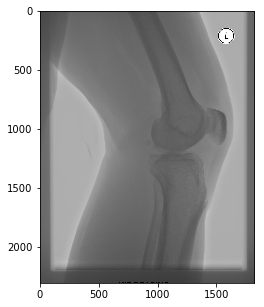

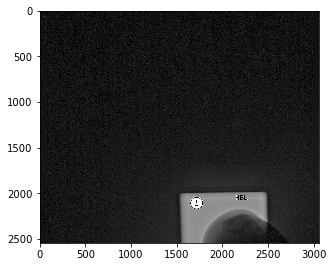

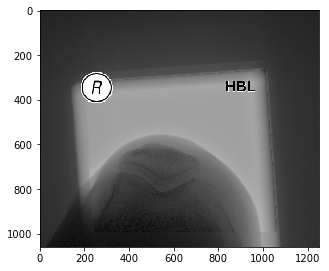

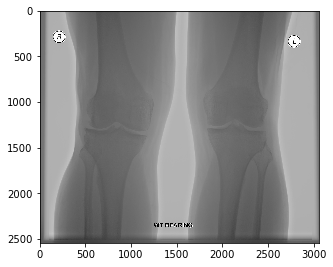

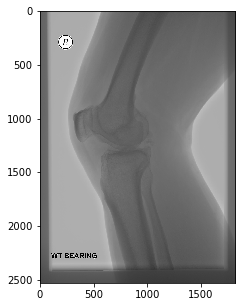

In [6]:
%pylab inline
pylab.rcParams['figure.figsize'] = (5, 5)

pd.options.display.max_colwidth = 4000

patient_ids = []
for folder in os.listdir(dir+'data/Images'):
    #os.path.exists(self.labelfilename)
    patient_ids.append(str(folder))

print len(patient_ids)
sample_patient = random.choice(patient_ids)
print sample_patient

report_sample = df.loc[df['Accession'] == sample_patient]['Report text']
print report_sample

sample_exam = []
for image in os.listdir(dir + 'data/Images/' + str(sample_patient)):
    if image.endswith('.jpg'):
        im = plt.imread(dir + 'data/Images/' + str(sample_patient) + '/' + str(image))
        sample_exam.append(im)
        plt.figure()
        plt.imshow(im)
        im.shape

## 1.3 Extract CNN image embeddings
From second-to-last layer of GoogLeNet CNN pretrained on ImageNet

In [6]:
# print(theano.config)

Build the model and select layers we need - the features are taken from the final network layer, before the softmax nonlinearity.


In [7]:
cnn_layers = googlenet.build_model()
cnn_input_var = cnn_layers['input'].input_var
cnn_feature_layer = cnn_layers['loss3/classifier']
cnn_output_layer = cnn_layers['prob']

get_cnn_features = theano.function([cnn_input_var], lasagne.layers.get_output(cnn_feature_layer))

Load the pretrained weights into the network


In [8]:
model_param_values = pickle.load(open('models/blvc_googlenet.pkl'))['param values']
lasagne.layers.set_all_param_values(cnn_output_layer, model_param_values)

The images need some preprocessing before they can be fed to the CNN


In [9]:
MEAN_VALUES = np.array([104, 117, 123]).reshape((3,1,1))

def prep_image(im):
    if len(im.shape) == 2:
        im = im[:, :, np.newaxis]
        im = np.repeat(im, 3, axis=2)
    # Resize so smallest dim = 224, preserving aspect ratio
    h, w, _ = im.shape
    if h < w:
        im = skimage.transform.resize(im, (224, w*224/h), preserve_range=True)
    else:
        im = skimage.transform.resize(im, (h*224/w, 224), preserve_range=True)

    # Central crop to 224x224
    h, w, _ = im.shape
    im = im[h//2-112:h//2+112, w//2-112:w//2+112]
    
    rawim = np.copy(im).astype('uint8')
    
    # Shuffle axes to c01
    im = np.swapaxes(np.swapaxes(im, 1, 2), 0, 1)
    
    # Convert to BGR
    im = im[::-1, :, :]

    im = im - MEAN_VALUES
    return rawim, floatX(im[np.newaxis])

In [9]:
# convert png to jpg
# import os
# from PIL import Image

# for folder in os.listdir(dir+'data/Images'):
#     for image in os.listdir(dir+'data/Images/' + str(folder)):
#         print image
#         try:
#             im = Image.open(dir+'data/Images/' + str(folder) + '/' + str(image))
#             rgb_im = im.convert('RGB')
#             new_fn = os.path.splitext(image)[0] + '.jpg'
#             print new_fn
#             rgb_im.save(dir+'data/Images/' + str(folder) + '/' + new_fn)
#         except IOError, e:
#             print "error opening file :: %s : %s" % (dir+'data/Images/' + str(folder) + '/' + str(image), e)
#             continue


# print len(patient_ids)

In [10]:
prepd_images = []
for im in sample_exam:
    rawim, cnn_im = prep_image(im)
    prepd_images.append((rawim, cnn_im))

/vol/medic02/users/ag6516/miniconda/envs/TheanoLasagne/lib/python2.7/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [11]:
CLASSES = pickle.load(open('models/blvc_googlenet.pkl'))['synset words']
for im in prepd_images:
    p = get_cnn_features(im[1])
    #print p.shape
    print(CLASSES[p.argmax()])

bathtub, bathing tub, bath, tub
television, television system
television, television system
mosquito net
shower curtain


Extract a sample of images, assign the corresponding report and a 'view' label for each image (if it has one). Views are:
1. AP - anteroposterior
2. HBL - horizontal beam lateral
3. S - skyline
4. L - lateral
5. WBAP - weight bearing anteroposterior
6. WBL - weight bearing lateral

In [12]:
sample_images = []
views = {}
for pid in patient_ids:
    for image in os.listdir(dir + 'data/Images/' + str(pid)):
        if image.endswith('.jpg'):
            item = {}
            imid = os.path.splitext(image)[0] 
            item['patient id'] = pid
            item['impath'] = pid + '/' + image
            if pid in labels:
                item['report'] = reports[labels.index(pid)]
                item['tokens'] = reports_tok[labels.index(pid)]
                if '_' in image:             
                    leg = imid.split('_')[-1]
                    view = imid.split('_')[-2]
                
                    item['imid'] = imid.split('_')[0]
                    item['leg'] = leg
                    item['view'] = view
                    if view not in views.keys():
                        views[view] = 0
                    views[view] = views[view] + 1
                else:
                    item['imid'] = imid
            else: continue

            sample_images.append(item)
print views

pickle.dump(sample_images, open('sample_images.pkl','w'), protocol=pickle.HIGHEST_PROTOCOL)

{'HBL': 12, 'WBAP': 34, 'L': 90, 'AP': 69, 'S': 33, 'WBL': 17}


Extract CNN features for each image

In [ ]:
for item in sample_images:
    path = dir + 'data/Images/' + item['impath']
    #try:
    im = plt.imread(path)
    _, cnn_input = prep_image(im)
    #except IOError:
    #        continue
    features = get_cnn_features(cnn_input)
    item['cnn features'] = features

Train/test/val split

In [ ]:
train1, test = model_selection.train_test_split(sample_images, train_size=0.8, random_state=42)
train, val = model_selection.train_test_split(train1, train_size=0.8, random_state=42)

for item in train:
    item['split'] = 'train'

for item in val:
    item['split'] = 'val'

for item in test:
    item['split'] = 'test'

In [ ]:
sample_images = train+test+val
print 'Train: ', len(train)
print 'Val: ', len(val)
print 'Test: ', len(test)
print 'Total', len(sample_images)

In [ ]:
pickle.dump(sample_images, open('sample_images_cnn_features.pkl','w'), protocol=pickle.HIGHEST_PROTOCOL)

# 2. Visualise Combined Image-Text Embedding
Report embedding and image embeddings can be generated out-of-the-box using pre-trained models. They can then be combined into a joint embedding space and visualised.

One scheme of creating joint embeddings is __[DeViSE](http://papers.nips.cc/paper/5204-devise-a-deep-visual-semantic-embedding-model.pdf)__ (Deep Visual Semantic Embedding Model) from Frome et. al. They take the output before softmax from a pre-trained classification network (AlexNet) and the embedding layer from a pre-trained SkipGram neural language model, and map to the same embedding space by training the visual model to predict the sentence embedding by means of a 'projection' layer (a linear layer that maps the image representation into the space dimensionality of the text embedding space).  <img src="devise.png">

In this implementation, report embeddings are generated by __[InferSent](https://github.com/facebookresearch/InferSent)__, of dimension 4096, and the image model used is the GoogLeNet model pretrained on ImageNet. In order for the dimension of the output of the pre-trained image model to be the same as the text embedding, the last fully connected layer (after the last average pooling layer) is replaced with one of size 4096. 

## 2.1 Generate InferSent Embeddings 

In [13]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

torch.set_num_threads(1)

GLOVE_PATH = dir + 'InferSent/GloVe/glove.840B.300d.txt'

In [14]:
model_is = torch.load('models/infersent.allnli.pickle')
model_is.set_glove_path(GLOVE_PATH)

/vol/medic02/users/ag6516/miniconda/envs/TheanoLasagne/lib/python2.7/site-packages/torch/serialization.py:286: SourceChangeWarning: source code of class 'models.BLSTMEncoder' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/vol/medic02/users/ag6516/miniconda/envs/TheanoLasagne/lib/python2.7/site-packages/torch/serialization.py:286: SourceChangeWarning: source code of class 'torch.nn.modules.rnn.LSTM' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [15]:
dataset = pickle.load(open('sample_images_cnn_features.pkl'))

In [16]:
model_is.build_vocab(reports, tokenize=True)

joint_embedding = []
for item in dataset:
    report = item['report']
    report_embedding = model_is.encode(report, bsize=128, tokenize=True, verbose=True)
    item['report embedding'] = report_embedding[0]
    print report_embedding[0].shape
    
#embeddings_is = model_is.encode(reports, bsize=128, tokenize=True, verbose=True)
#print('nb sentences encoded : {0}'.format(len(embeddings_is)))

Found 1496(/1739) words with glove vectors
Vocab size : 1496
Nb words kept : 718/874 (82.15 %)


models.py:53: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greately increasing memory usage. To compact weights again call flatten_parameters().
  sent_output = self.enc_lstm(sent_packed)[0]  # seqlen x batch x 2*nhid


Speed : 165.28 sentences/s (gpu mode, bsize=128)
(4096,)
Nb words kept : 742/911 (81.45 %)
Speed : 2943.42 sentences/s (gpu mode, bsize=128)
(4096,)
Nb words kept : 437/537 (81.38 %)
Speed : 2336.89 sentences/s (gpu mode, bsize=128)
(4096,)
Nb words kept : 313/384 (81.51 %)
Speed : 2359.9 sentences/s (gpu mode, bsize=128)
(4096,)
Nb words kept : 472/585 (80.68 %)
Speed : 3028.81 sentences/s (gpu mode, bsize=128)
(4096,)
Nb words kept : 8/8 (100.0 %)
Speed : 199.63 sentences/s (gpu mode, bsize=128)
(4096,)
Nb words kept : 742/911 (81.45 %)
Speed : 3232.84 sentences/s (gpu mode, bsize=128)
(4096,)
Nb words kept : 522/637 (81.95 %)
Speed : 3278.98 sentences/s (gpu mode, bsize=128)
(4096,)
Nb words kept : 72/90 (80.0 %)
Speed : 1263.04 sentences/s (gpu mode, bsize=128)
(4096,)
Nb words kept : 349/431 (80.97 %)
Speed : 2541.63 sentences/s (gpu mode, bsize=128)
(4096,)
Nb words kept : 673/815 (82.58 %)
Speed : 3272.92 sentences/s (gpu mode, bsize=128)
(4096,)
Nb words kept : 203/244 (83.2 %)

In [17]:
pickle.dump(dataset, open('sample_infersent_embeddings_googlenet_features.pkl','w'), protocol=pickle.HIGHEST_PROTOCOL)

## 2.2 Create and train DeViSE model

In [22]:
BATCH_SIZE = 1
FC_SIZE = 4096
EMBEDDING_SIZE = 4096

In [25]:
cnn_layers = googlenet.build_model()
model_param_values = pickle.load(open('models/blvc_googlenet.pkl'))['param values']
lasagne.layers.set_all_param_values(cnn_layers['prob'], model_param_values)

In [26]:
# cnn feature vector
x_cnn = T.matrix()

# sentence embedding
y_sentence = T.imatrix()

In [27]:
#cnn_input_var = cnn_layers['input'].input_var
cnn_pooling_layer = cnn_layers['pool5/7x7_s1']
#cnn_embedding_layer = cnn_layers['loss3/classifier']

# Replace the last fully connected layer of dim 1000 with a FC layer of dim FC_SIZE
cnn_output_layer = lasagne.layers.DenseLayer(cnn_pooling_layer, num_units=FC_SIZE, nonlinearity=None)

# Connect to linear embedding layer (the Transformation Layer)
cnn_transformation_layer = lasagne.layers.DenseLayer(cnn_output_layer, num_units = EMBEDDING_SIZE, nonlinearity=None)

The loss defined in the DeViSE set-up is a combination of dot-product similarity and hinge rank loss:
<img src='devise_loss.png'>

We can also minimise cosine distance or L2 as a comparison

In [28]:
def cosine_similarity(u, v):
    inner = T.dot(u, v)
    u_norm = T.sqrt(T.sum(T.sqr(u)))
    v_norm = T.sqrt(T.sum(T.sqr(v)))
    return inner / u_norm * v_norm

def calc_loss(net_output, targets):

    cost = cosine_similarity(net_output, targets)
    return cost

In [31]:
prediction = lasagne.layers.get_output(cnn_transformation_layer, x_cnn)

loss = T.mean(calc_loss(x_cnn, y_sentence))

params = lasagne.layers.get_all_params(cnn_transformation_layer, trainable=True)
updates = lasagne.updates.adam(loss, params, learning_rate=0.0001)

get_cnn_features = theano.function([x_cnn], lasagne.layers.get_output(cnn_transformation_layer))

TypeError: img must be 4D tensor

In [ ]:
for iteration in range(20000):
    x_cnn, x_sentence, y_sentence, mask = prep_batch_for_network(get_data_batch(dataset, BATCH_SIZE))
    loss_train, norm = f_train(x_cnn, x_sentence, mask, y_sentence)
    if not iteration % 250:
        print('Iteration {}, loss_train: {}, norm: {}'.format(iteration, loss_train, norm))
        try:
            batch = get_data_batch(dataset, BATCH_SIZE, split='val')
            x_cnn, x_sentence, y_sentence, mask = prep_batch_for_network(batch)
            loss_val = f_val(x_cnn, x_sentence, mask, y_sentence)
            print('Val loss: {}'.format(loss_val))
        except IndexError:
            continue

# 3. Build and Train LSTM for Report Generation
A single layer LSTM of sequence length = average report length is trained on the reports to predict the next word. The output of the LSTM of final time step can be thought of as an 'encoder' for the entire sentence, and can be plotted to visualise the sentence embeddings.

In [5]:
dataset = pickle.load(open('sample_images_cnn_features.pkl'))

In [6]:
allwords = Counter()
for item in dataset:
    tokens = item['tokens']
    #for sentence in item['sentences']:
    allwords.update(tokens)
        
vocab = [k for k, v in allwords.items() if v >= 5]
vocab.insert(0, '#START#')
vocab.append('#END#')

word_to_index = {w: i for i, w in enumerate(vocab)}
index_to_word = {i: w for i, w in enumerate(vocab)}

len(vocab)

385

## 3.1 LSTM Model
Simple LSTM model that learns to predict the next word in a sequence. The final hidden layer can be used as the text 'embedding'

In [58]:
SEQUENCE_LENGTH = 32
MAX_SENTENCE_LENGTH = SEQUENCE_LENGTH - 2 # 1 for start token, 1 for end token
BATCH_SIZE = 1
EMBEDDING_SIZE = 256

In [59]:
# Returns training batch
def get_data_batch(dataset, size, split='train'):
    items = []
    while len(items) < size:
        item = random.choice(dataset)
        if item['split'] != split:
            continue
        sentence = item['tokens']
        if len(sentence) > MAX_SENTENCE_LENGTH:
            sentence = sentence[1:MAX_SENTENCE_LENGTH]
            #continue
        items.append(sentence)
    
    return items

In [60]:
# Convert batch input into arrays that can be fed into the network
def prep_batch_for_network(batch):
    x_sentence = np.zeros((len(batch), SEQUENCE_LENGTH), dtype='int32')
    y_sentence = np.zeros((len(batch), SEQUENCE_LENGTH), dtype='int32')
    mask = np.zeros((len(batch), SEQUENCE_LENGTH), dtype='bool')

    for j, sentence in enumerate(batch):
        i = 0
        for word in ['#START#'] + sentence + ['#END#']:
            if word in word_to_index:
                mask[j, i] = True
                y_sentence[j, i] = word_to_index[word]
                x_sentence[j, i] = word_to_index[word]
                i += 1
        #mask[j, 0] = False
                
    return x_sentence, y_sentence, mask

In [61]:
# sentence embedding maps integer sequence with dim (BATCH_SIZE, SEQUENCE_LENGTH - 1) to 
# (BATCH_SIZE, SEQUENCE_LENGTH-1, EMBEDDING_SIZE)
l_input_sentence = lasagne.layers.InputLayer((BATCH_SIZE, SEQUENCE_LENGTH))
l_sentence_embedding = lasagne.layers.EmbeddingLayer(l_input_sentence,
                                                     input_size=len(vocab),
                                                     output_size=EMBEDDING_SIZE,
                                                    )
# rnn input
l_dropout_input = lasagne.layers.DropoutLayer(l_sentence_embedding, p=0.5)
l_lstm = lasagne.layers.LSTMLayer(l_dropout_input,
                                  num_units=EMBEDDING_SIZE,
                                  unroll_scan=True,
                                  grad_clipping=5.)
l_dropout_output = lasagne.layers.DropoutLayer(l_lstm, p=0.5)

# the RNN output is reshaped to combine the batch and time dimensions
# dim (BATCH_SIZE * SEQUENCE_LENGTH, EMBEDDING_SIZE)
l_shp = lasagne.layers.ReshapeLayer(l_dropout_output, (-1, EMBEDDING_SIZE))

# decoder is a fully connected layer with one output unit for each word in the vocabulary
l_decoder = lasagne.layers.DenseLayer(l_shp, num_units=len(vocab), nonlinearity=lasagne.nonlinearities.softmax)

# finally, the separation between batch and time dimension is restored
l_out = lasagne.layers.ReshapeLayer(l_decoder, (BATCH_SIZE, SEQUENCE_LENGTH, len(vocab)))

In [62]:
# sentence encoded as sequence of integer word tokens
x_sentence_sym = T.imatrix()

# mask defines which elements of the sequence should be predicted
mask_sym = T.imatrix()

# ground truth for the RNN output
y_sentence_sym = T.imatrix()

In [63]:
output = lasagne.layers.get_output(l_out, {
                l_input_sentence: x_sentence_sym
                })

In [64]:
def calc_cross_ent(net_output, mask, targets):
    # Helper function to calculate the cross entropy error
    preds = T.reshape(net_output, (-1, len(vocab)))
    targets = T.flatten(targets)
    cost = T.nnet.categorical_crossentropy(preds, targets)[T.flatten(mask).nonzero()]
    return cost

loss = T.mean(calc_cross_ent(output, mask_sym, y_sentence_sym))

In [23]:
MAX_GRAD_NORM = 15

all_params = lasagne.layers.get_all_params(l_out, trainable=True)

all_grads = T.grad(loss, all_params)
all_grads = [T.clip(g, -5, 5) for g in all_grads]
all_grads, norm = lasagne.updates.total_norm_constraint(
    all_grads, MAX_GRAD_NORM, return_norm=True)

updates = lasagne.updates.adam(all_grads, all_params, learning_rate=0.001)

f_train = theano.function([x_sentence_sym, mask_sym, y_sentence_sym],
                          [loss, norm],
                          updates=updates
                         )

f_val = theano.function([x_sentence_sym, mask_sym, y_sentence_sym], loss)

## 3.2 Training

In [24]:
for iteration in range(20000):
    x_sentence, y_sentence, mask = prep_batch_for_network(get_data_batch(dataset, BATCH_SIZE))
    loss_train, norm = f_train(x_sentence, mask, y_sentence)
    if not iteration % 250:
        print('Iteration {}, loss_train: {}, norm: {}'.format(iteration, loss_train, norm))
        try:
            batch = get_data_batch(dataset, BATCH_SIZE, split='val')
            x_sentence, y_sentence, mask = prep_batch_for_network(batch)
            loss_val = f_val(x_sentence, mask, y_sentence)
            print('Val loss: {}'.format(loss_val))
        except IndexError:
            continue

Iteration 0, loss_train: 5.95290136337, norm: 0.37345340848
Val loss: 5.9501080513
Iteration 250, loss_train: 1.58609688282, norm: 2.29238700867
Val loss: 4.05609607697
Iteration 500, loss_train: 1.06594157219, norm: 1.2797421217
Val loss: 1.53818452358
Iteration 750, loss_train: 0.384077429771, norm: 1.25179755688
Val loss: 0.836719751358
Iteration 1000, loss_train: 0.87213498354, norm: 1.33759284019
Val loss: 2.97347426414
Iteration 1250, loss_train: 0.204834774137, norm: 1.11425197124
Val loss: 1.68603289127
Iteration 1500, loss_train: 0.151814267039, norm: 0.690633237362
Val loss: 0.739938259125
Iteration 1750, loss_train: 0.153661653399, norm: 0.615751087666
Val loss: 0.0180528182536
Iteration 2000, loss_train: 0.772134423256, norm: 1.73097538948
Val loss: 0.0389688499272
Iteration 2250, loss_train: 0.625367701054, norm: 1.41370284557
Val loss: 0.913826942444
Iteration 2500, loss_train: 0.0287756007165, norm: 0.192129716277
Val loss: 0.0289207864553
Iteration 2750, loss_train: 0.0

In [25]:
param_values = lasagne.layers.get_all_param_values(l_out)
d = {'param values': param_values,
     'vocab': vocab,
     'word_to_index': word_to_index,
     'index_to_word': index_to_word,
    }
pickle.dump(d, open('lstm_knee_xray_trained_text_only.pkl','w'), protocol=pickle.HIGHEST_PROTOCOL)

## 3.3 Extract Report Embeddings from LSTM layer
Load trained model, use LSTM encoder layer to generate report embeddings

In [65]:
d = pickle.load(open('lstm_knee_xray_trained_text_only.pkl'))
vocab = d['vocab']
word_to_index = d['word_to_index']
index_to_word = d['index_to_word']
lasagne.layers.set_all_param_values(l_out, d['param values'])

In [66]:
encoder_output = lasagne.layers.get_output(l_lstm, {
                l_input_sentence: x_sentence_sym
                })

f = theano.function([x_sentence_sym], encoder_output)

word_embeddings = floatX(np.zeros((len(dataset), SEQUENCE_LENGTH, EMBEDDING_SIZE)))

for i, item in enumerate(dataset):
    x_sentence = np.zeros((1, SEQUENCE_LENGTH), dtype='int32')
    
    for j, word in enumerate(['#START#'] + item['tokens'][1:MAX_SENTENCE_LENGTH] + ['#END#']):
        if word in word_to_index:
            x_sentence[0,j] = word_to_index[word]

    word_embedding = f(x_sentence)
    word_embeddings[i, :, :] = word_embedding[0, :, :]
    
print word_embeddings.shape
lstm_report_embeddings = np.sum(word_embeddings, axis = 1)
print lstm_report_embeddings.shape

(1432, 32, 256)
(1432, 256)


# 4. Build and Train LSTM Image Captioning model
An LSTM can be trained for image caption generation by incorporating the image embedding (obtained from a CNN) as an extra 'word' input along with the rest of the caption. We can visualise the joint image-text embedding by extracting the final LSTM hidden state.
We can observe the effect of including the image as an extra input by comparing against the report embeddings on their own.

In this implementation, a single layer LSTM, trained on concatented input of report and image: input sequence = image embedding (1) + (start token) + report (30) + (end token) 

In [45]:
SEQUENCE_LENGTH = 33
MAX_SENTENCE_LENGTH = SEQUENCE_LENGTH - 3 # 1 for image, 1 for start token, 1 for end token
#BATCH_SIZE = 50
BATCH_SIZE = 1
CNN_FEATURE_SIZE = 1000
EMBEDDING_SIZE = 256

In [46]:
# Returns a list of tuples (cnn features, list of words, image ID)
def get_data_batch(dataset, size, split='train'):
    items = []
    
    while len(items) < size:
        item = random.choice(dataset)
        if item['split'] != split:
            continue
        sentence = item['tokens']
        if len(sentence) > MAX_SENTENCE_LENGTH:
            sentence = sentence[1:MAX_SENTENCE_LENGTH]
            #continue
        items.append((item['cnn features'], sentence, item['imid']))
    
    return items

In [47]:
# Convert a list of tuples into arrays that can be fed into the network
def prep_batch_for_network(batch):
    x_cnn = floatX(np.zeros((len(batch), 1000)))
    x_sentence = np.zeros((len(batch), SEQUENCE_LENGTH - 1), dtype='int32')
    y_sentence = np.zeros((len(batch), SEQUENCE_LENGTH), dtype='int32')
    mask = np.zeros((len(batch), SEQUENCE_LENGTH), dtype='bool')

    for j, (cnn_features, sentence, _) in enumerate(batch):
        x_cnn[j] = cnn_features
        i = 0
        for word in ['#START#'] + sentence + ['#END#']:
            if word in word_to_index:
                mask[j, i] = True
                y_sentence[j, i] = word_to_index[word]
                x_sentence[j, i] = word_to_index[word]
                i += 1
        #mask[j, 0] = False
                
    return x_cnn, x_sentence, y_sentence, mask

In [48]:
# sentence embedding maps integer sequence with dim (BATCH_SIZE, SEQUENCE_LENGTH - 1) to 
# (BATCH_SIZE, SEQUENCE_LENGTH-1, EMBEDDING_SIZE)
l_input_sentence = lasagne.layers.InputLayer((BATCH_SIZE, SEQUENCE_LENGTH - 1))
l_sentence_embedding = lasagne.layers.EmbeddingLayer(l_input_sentence,
                                                     input_size=len(vocab),
                                                     output_size=EMBEDDING_SIZE,
                                                    )

# cnn embedding changes the dimensionality of the representation from 1000 to EMBEDDING_SIZE, 
# and reshapes to add the time dimension - final dim (BATCH_SIZE, 1, EMBEDDING_SIZE)
l_input_cnn = lasagne.layers.InputLayer((BATCH_SIZE, CNN_FEATURE_SIZE))
l_cnn_embedding = lasagne.layers.DenseLayer(l_input_cnn, num_units=EMBEDDING_SIZE,
                                            nonlinearity=lasagne.nonlinearities.identity)

l_cnn_embedding = lasagne.layers.ReshapeLayer(l_cnn_embedding, ([0], 1, [1]))

# the two are concatenated to form the RNN input with dim (BATCH_SIZE, SEQUENCE_LENGTH, EMBEDDING_SIZE)
l_rnn_input = lasagne.layers.ConcatLayer([l_cnn_embedding, l_sentence_embedding])


l_dropout_input = lasagne.layers.DropoutLayer(l_rnn_input, p=0.5)
l_lstm = lasagne.layers.LSTMLayer(l_dropout_input,
                                  num_units=EMBEDDING_SIZE,
                                  unroll_scan=True,
                                  grad_clipping=5.)
l_dropout_output = lasagne.layers.DropoutLayer(l_lstm, p=0.5)

# the RNN output is reshaped to combine the batch and time dimensions
# dim (BATCH_SIZE * SEQUENCE_LENGTH, EMBEDDING_SIZE)
l_shp = lasagne.layers.ReshapeLayer(l_dropout_output, (-1, EMBEDDING_SIZE))

# decoder is a fully connected layer with one output unit for each word in the vocabulary
l_decoder = lasagne.layers.DenseLayer(l_shp, num_units=len(vocab), nonlinearity=lasagne.nonlinearities.softmax)

# finally, the separation between batch and time dimension is restored
l_out = lasagne.layers.ReshapeLayer(l_decoder, (BATCH_SIZE, SEQUENCE_LENGTH, len(vocab)))

In [49]:
# cnn feature vector
x_cnn_sym = T.matrix()

# sentence encoded as sequence of integer word tokens
x_sentence_sym = T.imatrix()

# mask defines which elements of the sequence should be predicted
mask_sym = T.imatrix()

# ground truth for the RNN output
y_sentence_sym = T.imatrix()

In [50]:
output = lasagne.layers.get_output(l_out, {
                l_input_sentence: x_sentence_sym,
                l_input_cnn: x_cnn_sym
                })

In [51]:
def calc_cross_ent(net_output, mask, targets):
    # Helper function to calculate the cross entropy error
    preds = T.reshape(net_output, (-1, len(vocab)))
    targets = T.flatten(targets)
    cost = T.nnet.categorical_crossentropy(preds, targets)[T.flatten(mask).nonzero()]
    return cost

loss = T.mean(calc_cross_ent(output, mask_sym, y_sentence_sym))

In [ ]:
MAX_GRAD_NORM = 15

all_params = lasagne.layers.get_all_params(l_out, trainable=True)

all_grads = T.grad(loss, all_params)
all_grads = [T.clip(g, -5, 5) for g in all_grads]
all_grads, norm = lasagne.updates.total_norm_constraint(
    all_grads, MAX_GRAD_NORM, return_norm=True)

updates = lasagne.updates.adam(all_grads, all_params, learning_rate=0.001)

f_train = theano.function([x_cnn_sym, x_sentence_sym, mask_sym, y_sentence_sym],
                          [loss, norm],
                          updates=updates
                         )

f_val = theano.function([x_cnn_sym, x_sentence_sym, mask_sym, y_sentence_sym], loss)

In [ ]:
for iteration in range(20000):
    x_cnn, x_sentence, y_sentence, mask = prep_batch_for_network(get_data_batch(dataset, BATCH_SIZE))
    loss_train, norm = f_train(x_cnn, x_sentence, mask, y_sentence)
    if not iteration % 250:
        print('Iteration {}, loss_train: {}, norm: {}'.format(iteration, loss_train, norm))
        try:
            batch = get_data_batch(dataset, BATCH_SIZE, split='val')
            x_cnn, x_sentence, y_sentence, mask = prep_batch_for_network(batch)
            loss_val = f_val(x_cnn, x_sentence, mask, y_sentence)
            print('Val loss: {}'.format(loss_val))
        except IndexError:
            continue

In [ ]:
param_values = lasagne.layers.get_all_param_values(l_out)
d = {'param values': param_values,
     'vocab': vocab,
     'word_to_index': word_to_index,
     'index_to_word': index_to_word,
    }
pickle.dump(d, open('lstm_knee_xray_trained.pkl','w'), protocol=pickle.HIGHEST_PROTOCOL)

## 4.1 Extract Image-Text Embeddings from LSTM layer
Load trained model, use LSTM encoder layer to generate joint image-text embeddings for each image/report pair

In [52]:
d = pickle.load(open('lstm_knee_xray_trained.pkl'))
vocab = d['vocab']
word_to_index = d['word_to_index']
index_to_word = d['index_to_word']
lasagne.layers.set_all_param_values(l_out, d['param values'])

In [53]:
encoder_output = lasagne.layers.get_output(l_lstm, {
                l_input_sentence: x_sentence_sym,
                l_input_cnn: x_cnn_sym
                })

f = theano.function([x_cnn_sym, x_sentence_sym], encoder_output)

joint_word_embeddings = floatX(np.zeros((len(dataset), SEQUENCE_LENGTH, EMBEDDING_SIZE)))

for i, item in enumerate(dataset):
    x_cnn = floatX(np.zeros((1, 1000)))
    x_sentence = np.zeros((1, SEQUENCE_LENGTH - 1), dtype='int32')
    x_cnn[0] = item['cnn features']
    
    for j, word in enumerate(['#START#'] + item['tokens'][1:MAX_SENTENCE_LENGTH] + ['#END#']):
        if word in word_to_index:
            x_sentence[0,j] = word_to_index[word]

    joint_word_embedding = f(x_cnn, x_sentence)
    joint_word_embeddings[i, :, :] = joint_word_embedding[0, :, :]
    
print joint_word_embeddings.shape
joint_embeddings = np.sum(joint_word_embeddings, axis = 1)
print joint_embeddings.shape

(1432, 33, 256)
(1432, 256)


In [ ]:
#print joint_embeddings[0,:]

In [ ]:
#%matplotlib notebook
#%matplotlib notebook
%matplotlib inline

reduced_data = PCA(n_components=2).fit_transform(joint_embeddings)
print reduced_data.shape
print type(reduced_data)
#print reduced_data[:, 1]
#x_min, x_max = reduced_data[:, 0].min(), reduced_data[:, 0].max()
#y_min, y_max = reduced_data[:, 1].min(), reduced_data[:, 1].max()

plt.figure()
plt.clf()

views_keys = {}
for i, v in enumerate(views):
    views_keys[v] = i

colours = plt.cm.jet(np.linspace(0, 1, len(views_keys)))

#plt.scatter(joint_embeddings[:,0], joint_embeddings[:, 1], alpha=.8, lw=2)  

for i, x, y in zip(range(len(sample_images)), reduced_data[:, 0], reduced_data[:, 1]):
    if 'view' in sample_images[i]:
        view = sample_images[i]['view']
        plt.scatter(x, y, color=colours[views_keys[view]], alpha=.8, lw=2)
    else:
        plt.scatter(x, y, color='C0', alpha=.8, lw=2)

#plt.xlim(x_min, x_max)
#plt.ylim(y_min, y_max)
#plt.xticks(())
#plt.yticks(())
plt.show()

# 5. Comparison of Embeddings

In [74]:
dataset = pickle.load(open('sample_report_embeddings_cnn_features.pkl'))

Populating the interactive namespace from numpy and matplotlib
(1432, 1000)
Found 546(/581) words with glove vectors
Vocab size : 546
Nb words kept : 37052/37754 (98.14 %)


models.py:53: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greately increasing memory usage. To compact weights again call flatten_parameters().
  sent_output = self.enc_lstm(sent_packed)[0]  # seqlen x batch x 2*nhid


Speed : 390.28 sentences/s (gpu mode, bsize=128)
(1432, 4096)
(1432, 256)
(1432, 256)


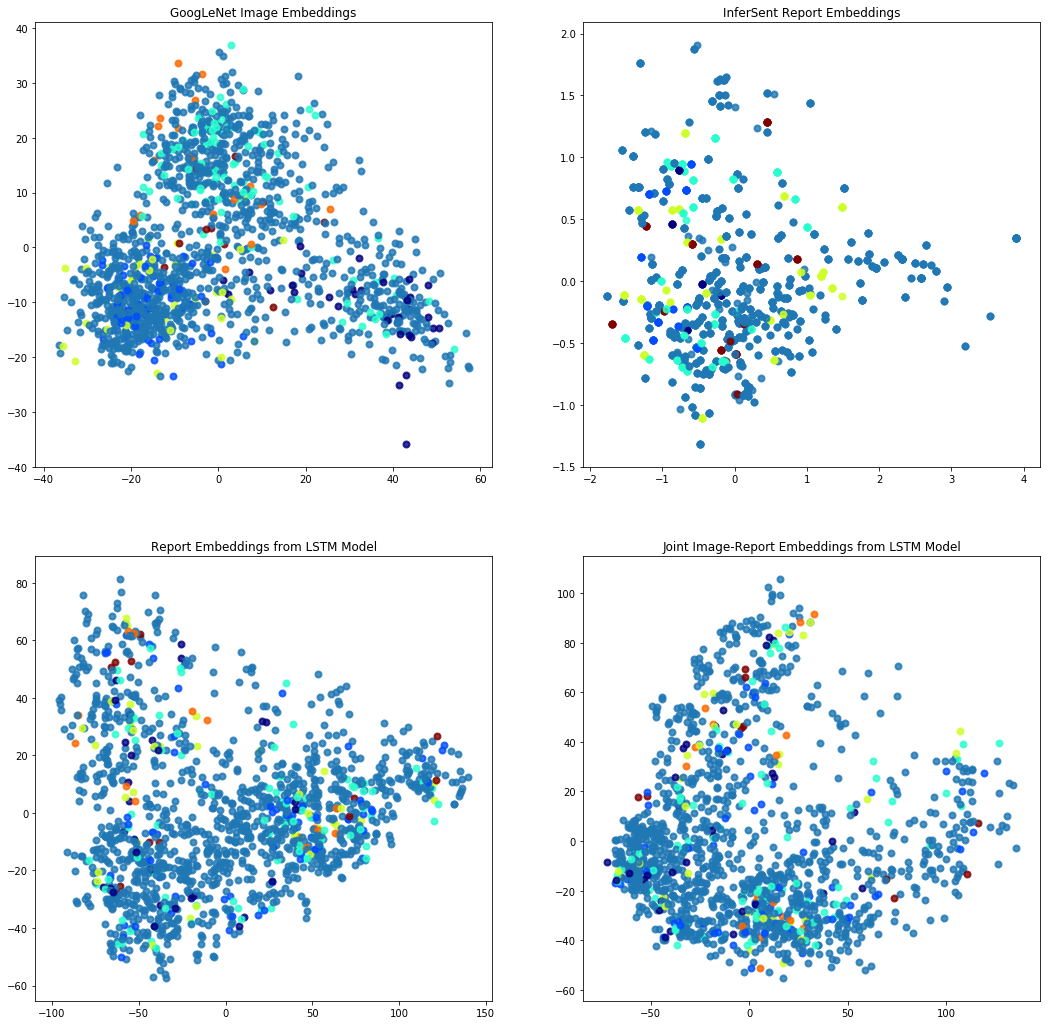

In [75]:
%pylab inline
pylab.rcParams['figure.figsize'] = (18, 18)

views_keys = {}
for i, v in enumerate(views):
    views_keys[v] = i

colours = plt.cm.jet(np.linspace(0, 1, len(views_keys)))

f, ax = plt.subplots(2, 2)

# Plot reduced googlenet image embeddings
cnn_embeddings = [item['cnn features'] for item in dataset]
cnn_embeddings = np.array(cnn_embeddings)
cnn_embeddings = cnn_embeddings.reshape((cnn_embeddings.shape[0], cnn_embeddings.shape[2]))
print cnn_embeddings.shape
cnn_reduced_embeddings = PCA(n_components=2).fit_transform(cnn_embeddings)

ax[0][0].set_title('GoogLeNet Image Embeddings')
for i, x, y in zip(range(len(dataset)), cnn_reduced_embeddings[:, 0], cnn_reduced_embeddings[:, 1]):
    if 'view' in dataset[i]:
        view = dataset[i]['view']
        ax[0][0].scatter(x, y, color=colours[views_keys[view]], alpha=.8, lw=2)
    else:
        ax[0][0].scatter(x, y, color='C0', alpha=.8, lw=2)


# Plot reduced InferSent report embeddings
#infersent_report_embeddings = [item['report embedding'] for item in dataset]
#infersent_report_embeddings = np.array(infersent_report_embeddings)
#cnn_embeddings = cnn_embeddings.reshape((cnn_embeddings.shape[0], cnn_embeddings.shape[2]))
sample_reports = [item['report'] for item in dataset]
model_is.build_vocab(sample_reports, tokenize=True)
infersent_report_embeddings = model_is.encode(sample_reports, bsize=128, tokenize=True, verbose=True)
print infersent_report_embeddings.shape
infersent_report_reduced_embeddings = PCA(n_components=2).fit_transform(infersent_report_embeddings)

ax[0][1].set_title('InferSent Report Embeddings')
for i, x, y in zip(range(len(dataset)), infersent_report_reduced_embeddings[:, 0], infersent_report_reduced_embeddings[:, 1]):
    _r = []
    for i, word in enumerate(dataset[i]['tokens']):
        _r.append(word)
        if i%5==0:
            _r.append(' \n ')
    _r = ' '.join(_r)
    
    if 'view' in dataset[i]:
        view = dataset[i]['view']
        ax[0][1].scatter(x, y, color=colours[views_keys[view]], alpha=.8, lw=2)
        #ax[0][1].annotate(_r, xy=(x, y), xytext=(0, 0), textcoords='offset points', color=colours[views_keys[view]])
        #continue
    else:
        #ax[0][1].annotate(_r, xy=(x, y), xytext=(0, 0), textcoords='offset points', color='C0')
        ax[0][1].scatter(x, y, color='C0', alpha=.8, lw=2)

# Plot reduced LSTM report embeddings
ax[1][0].set_title('Report Embeddings from LSTM Model')
lstm_report_reduced_data = PCA(n_components=2).fit_transform(lstm_report_embeddings)
print lstm_report_embeddings.shape

for i, x, y in zip(range(len(dataset)), lstm_report_reduced_data[:, 0], lstm_report_reduced_data[:, 1]):
    if 'view' in dataset[i]:
        view = dataset[i]['view']
        ax[1][0].scatter(x, y, color=colours[views_keys[view]], alpha=.8, lw=2)
    else:
        ax[1][0].scatter(x, y, color='C0', alpha=.8, lw=2)

# Plot reduced LSTM joint report embeddings
ax[1][1].set_title('Joint Image-Report Embeddings from LSTM Model')
joint_reduced_data = PCA(n_components=2).fit_transform(joint_embeddings)
print joint_embeddings.shape

for i, x, y in zip(range(len(dataset)), joint_reduced_data[:, 0], joint_reduced_data[:, 1]):
    if 'view' in dataset[i]:
        view = dataset[i]['view']
        ax[1][1].scatter(x, y, color=colours[views_keys[view]], alpha=.8, lw=2)
    else:
        ax[1][1].scatter(x, y, color='C0', alpha=.8, lw=2)